# **Introduction**
In recent years, there has been a growing interest in leveraging deep learning techniques to bridge the gap between computer vision and natural language understanding. Image captioning, a task that involves generating human-like descriptions for images, has emerged as a compelling application of this interdisciplinary research. By enabling machines to understand and describe visual content in natural language, image captioning holds promise for a wide range of applications, including assistive technologies for the visually impaired, content-based image retrieval, and enhancing human-computer interaction.

## **Project Goals**
The primary objective of this project is to develop a deep learning model capable of generating descriptive captions for images automatically. We aim to harness the complementary strengths of CNNs and LSTMs to extract meaningful image features and generate coherent textual descriptions. By training our model on the MS-COCO Dataset, we seek to demonstrate its ability to produce accurate and contextually relevant captions for a diverse range of images.

## **Dataset Description**
We will be using a subset of the MS-COCO dataset, which is a large-scale benchmark commonly used in image captioning and object detection research. This subset consists of 8,000 images sampled from the full MS-COCO dataset. Each image in this subset is annotated with five human-generated captions that describe the salient visual elements and contextual details of the scene. The captions capture a broad spectrum of objects, actions, and interactions within diverse real-world environments. By utilizing this richly annotated subset, we can train models to learn fine-grained associations between visual features and natural language, enabling effective generation of accurate and contextually relevant image descriptions.



# **Model Architecture:**
​
Our image captioning model architecture combines the strengths of Convolutional Neural Networks (CNNs) and Long Short-Term Memory networks (LSTMs). Here's how it works:
​
### **Convolutional Neural Network (CNN):**
​
We utilize a pre-trained CNN, such as VGG16 or ResNet, to extract features from input images. In the provided code, we use the VGG16 model pre-trained on the ImageNet dataset.
By removing the fully connected layers of the CNN and keeping the convolutional layers, we obtain a fixed-size feature vector representing each image's visual content.
​
### **Long Short-Term Memory network (LSTM):**
​
The LSTM component processes the image features extracted by the CNN and generates captions word by word.
In the code, we implement an LSTM-based sequence-to-sequence architecture, where the image features serve as input to the LSTM decoder.
The LSTM decoder generates a sequence of words one token at a time, conditioning each word on the previously generated words and the image features.


# **Training Process:**

Our model is trained using the MS-COCO Dataset, following these steps:

### **Feature Extraction:**

We use the pre-trained CNN (VGG16) to extract image features. These features are obtained by passing each image through the CNN and extracting the output of a specific layer.
In the provided code, we extract features from the 'block5_conv3' layer of VGG16, resulting in a 7x7x512 feature tensor for each image.

### **Caption Generation:**

The LSTM decoder takes the image features and generates captions word by word.
During training, the LSTM decoder is fed the image features along with the start token "<start>" to initiate the caption generation process.
The decoder generates the next word in the sequence based on the previous word and the image features, using teacher forcing to provide the ground truth word at each step.
    
### **Loss Calculation:**

We calculate the loss between the predicted captions and the ground truth captions using categorical cross-entropy loss.
The loss is computed over all time steps and all training samples and serves as a measure of how well the model is performing.

### **Evaluation and Fine-Tuning:**

We evaluate the model's performance using metrics such as BLEU score, which compares the generated captions with the reference captions.
Hyperparameters like learning rate, batch size, and optimizer settings are fine-tuned to improve the model's performance on the validation set.

# Import Modules

In [ ]:
!pip install kagglehub

In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from tensorflow.keras.models import load_model

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

In [2]:
import kagglehub

path = kagglehub.dataset_download("sahilkarne/ms-coco-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/ms-coco-dataset


#### Now we must set the directories to use the data

In [3]:
BASE_DIR = '/kaggle/input/ms-coco-dataset'
WORKING_DIR = '/content/drive/MyDrive/Colab Notebooks/TY/Deep Learning/Lab Assignment 6.1'

# Extract Image Features

We have to load and restructure the model

VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


+ Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

+ By preference you may include more layers, but for quicker results avoid adding the unnecessary layers.

# Extract the image features
Now we extract the image features and load the data for preprocess

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Dictionary 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to preprocess in a RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store your dictionary in a pickle for reloading it to save time

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load all your stored feature data to your project for quicker runtime

## Load the Captions Data

Let us store the captions data from the text file

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Now we split and append the captions data with the image

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

+ Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text

+ Same image may have multiple captions, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image

#### Now let us see the no. of images loaded

In [ ]:
len(mapping)

8091

# Preprocess Text Data

In [ ]:

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Defined to clean and convert the text for quicker process and better results

Let us visualize the text **before** and **after** cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

No. of unique captions stored

# 10 Captions
Let us see the first ten captions

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Processing of Text Data
Now we start processing the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

No. of unique words

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

+ Finding the maximum length of the captions, used for reference for the padding sequence.

# Train Test Split

#### After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Now we will define a batch and include the padding sequence**

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

# Model Creation

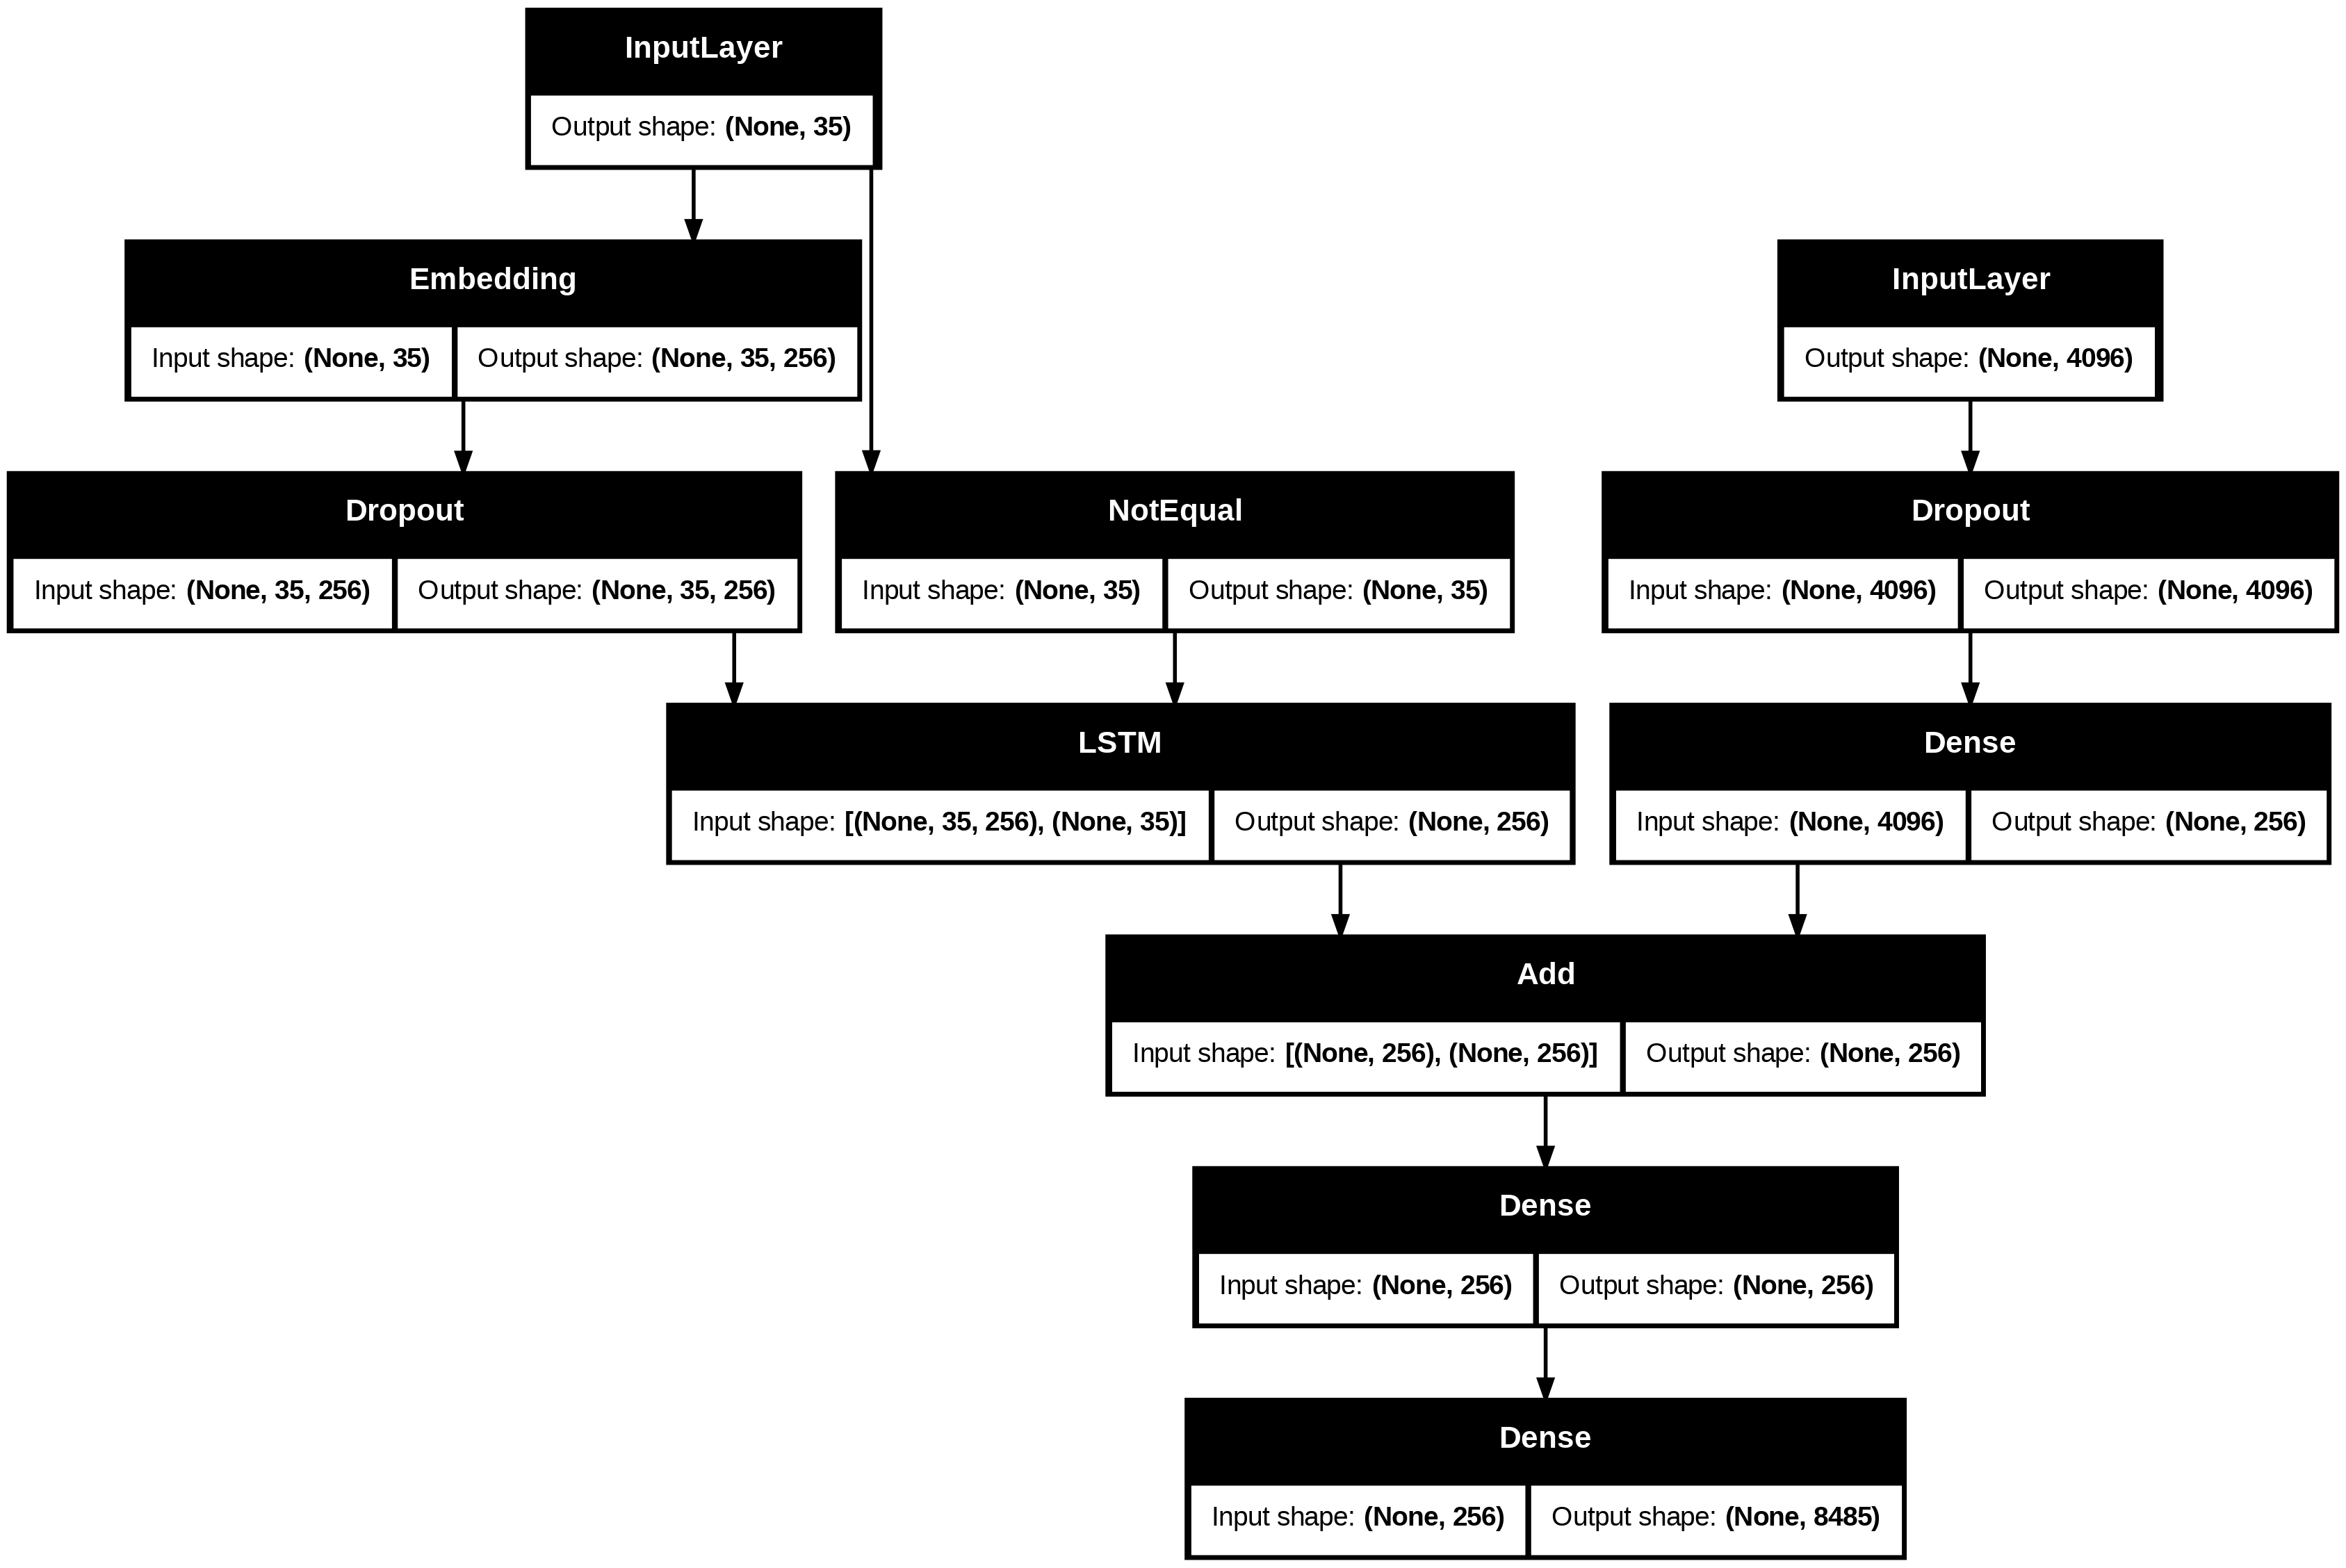

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

+ **shape=(4096,)** - output length of the features from the VGG model

+ **Dense** - single dimension linear layer array

+ **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

+ **model.compile()** - compilation of the model

+ **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

+ **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

+ Model plot shows the concatenation of the inputs and outputs into a single layer

+ Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Train Model
Now let us train the model

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(
    generator,
    epochs=20,
    steps_per_epoch=steps,
    verbose=1
)


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 583s 3s/step - loss: 5.7935
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - loss: 4.0516
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 185s 815ms/step - loss: 3.5822
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 132s 585ms/step - loss: 3.3064
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 103s 455ms/step - loss: 3.0974
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 92s 406ms/step - loss: 2.9418
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 392ms/step - loss: 2.8220
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 93s 410ms/step - loss: 2.7308
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 78s 344ms/step - loss: 2.6528
Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 78s 342ms/step - loss: 2.5814
Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 391ms/step - loss: 2.5230
Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 78s 344ms/step - loss: 2.4747
Epoch 13/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 312ms/step - loss: 2.4119
Epoch 14/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 311ms/step - loss: 2.3769
Epoch 15/20
227/

+ **steps = len(train) // batch_size** - back propagation and fetch the next data

+ Loss decreases gradually over the iterations

+ Increase the no. of epochs for better results

+ Assign the no. of epochs and batch size accordingly for quicker results


### You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR + '/best_model.keras')


In [ ]:
model = load_model(WORKING_DIR + '/best_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

+ Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

+ Captiongenerator appending all the words for an image

+ The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

# Model Validation
Now we validate the data using BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.535489
BLEU-2: 0.306791


+ BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

+ The reference text contains all the words appended from the captions data (actual_captions)

+ A BLEU Score more than **0.4 is considered a good result**, for a better score increase the no. of epochs accordingly.

## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

+ Image caption generator defined

+ First prints the actual captions of the image then prints a predicted caption of the image

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the ground endseq


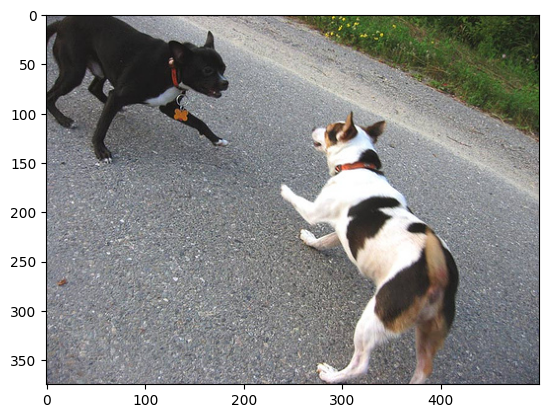

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pigtails sits in front of green tent endseq


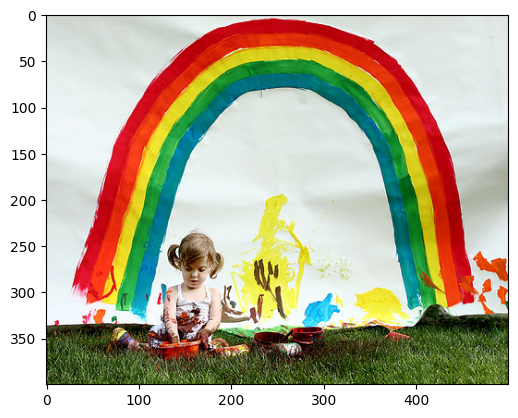

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq black dog in front of tree jumping towards red frisbee endseq
startseq dog jumps through the grass endseq
startseq grey dog jumps in the air to catch frisbee in grassy park endseq
startseq shaggy dog jumps outside in the grass endseq
startseq the black dog is jumping up in the air endseq
--------------------Predicted--------------------
startseq black dog is running on the grass endseq


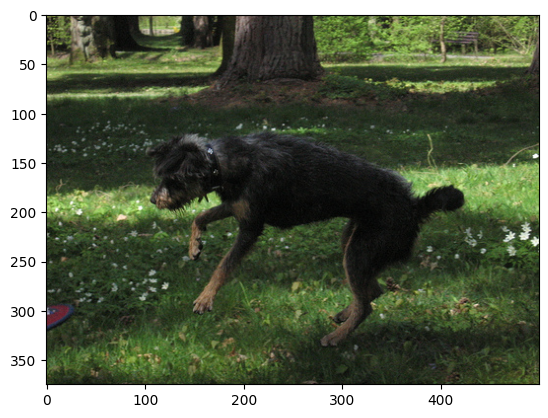

In [ ]:
import random

random_image_id = random.choice(test)
image_name = random_image_id + ".jpg"  # Construct the image file name

generate_caption(image_name)

## Evaluation Metrics

In [ ]:
!pip install pycocoevalcap

### BLEU

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from pycocoevalcap.bleu.bleu import Bleu

# BLEU
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.535489
BLEU-2: 0.306791
BLEU-3: 0.190319
BLEU-4: 0.110087


### CIDEr

In [ ]:
from pycocoevalcap.cider.cider import Cider

# Create dictionaries for CIDEr
actual_dict = {}
predicted_dict = {}

for i, key in enumerate(test):
    actual_dict[key] = [" ".join(caption) for caption in actual[i]]  # Join words in actual captions
    predicted_dict[key] = [" ".join(predicted[i])]  # Join words in predicted caption


# CIDEr
cider_scorer = Cider()
cider_score = cider_scorer.compute_score(actual_dict, predicted_dict)[0]  # Use dictionaries here
print(f"CIDEr: {cider_score}")


CIDEr: 0.2895061282924298


### METEOR

In [ ]:
from pycocoevalcap.meteor.meteor import Meteor

# METEOR
meteor_scorer = Meteor()
meteor_score = meteor_scorer.compute_score(actual_dict, predicted_dict)
print(f"METEOR: {meteor_score}")


METEOR: (0.21543746177995762, [0.2486862184367517, 0.3040867874943186, 0.21203617318026452, 0.17324879465438736, 0.2521892557884471, 0.13223140495867766, 0.16045845272206302, 0.21677374661152943, 0.16109839816933638, 0.1899013967928137, 0.28906946336406414, 0.2195177180876247, 0.19277108433734938, 0.12743362831858407, 0.2415117782382152, 0.2171225736465116, 0.20830343611779523, 0.2501731523795005, 0.19207690300783878, 0.15558608087799178, 0.2679435151249806, 0.24598439331804756, 0.2632768137046342, 0.18757387788919522, 0.3142659900330781, 0.3488583075901802, 0.18633876867730023, 0.13817591436845889, 0.26700966272952825, 0.14732965009208104, 0.17742938765883512, 0.2400350060413696, 0.12140077821011673, 0.18430922311519327, 0.26557509739080626, 0.15505698581154104, 0.18867924528301885, 0.3115734965709173, 0.12307936110602569, 0.2957706885587155, 0.3006650498005867, 0.20834015876048764, 0.14682636875466645, 0.3883405346629521, 0.15714285714285714, 0.1246458923512748, 0.23583285080409358, 

### SPICE

In [ ]:
from pycocoevalcap.spice.spice import Spice

spice_scorer = Spice()
spice_score, _ = spice_scorer.compute_score(actual_dict, predicted_dict)
print(f"SPICE: {spice_score}")


SPICE: 0.15405150378090438


# Final Thoughts

+ Training the model by increasing the no. of epochs can give better and more accurate results.

+ Processing large amount of data can take a lot of time and system resource.

+ The no. of layers of the model can be increased if you want to process entire dataset like MS-COCO Dataset.



**In this project , we have built an Image Caption Generator exploring the MS-COCO Dataset as an advanced deep learning project using different models from image extraction and text based processing.**